In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna

In [3]:
df = pd.read_csv('data/breast-cancer.csv')
df = df.drop(columns=['id'])

## Label encoding for the diagnosis column

In [4]:
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
y = df['diagnosis']
X = df.drop(columns=['diagnosis'])

## Split the data into training and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Simple training

In [6]:
# Select the model
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_leaf=0.12, random_state=42)

# Fit rf to the training set
rf_classifier.fit(X_train, y_train) 

# Predict the test set labels
y_pred = rf_classifier.predict(X_test)

# Evaluate the test set RMSE
accuracy = accuracy_score(y_test, y_pred)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(accuracy))

Test set RMSE of rf: 0.95


## Feature Importance

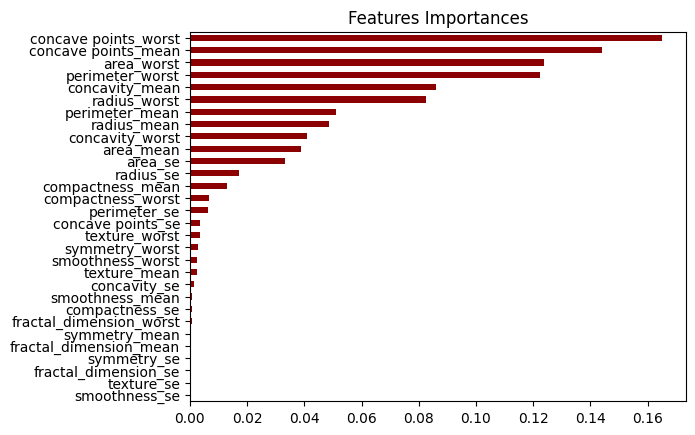

In [7]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf_classifier.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='darkred')
plt.title('Features Importances')
plt.show()

## Grid Search

In [8]:
# The hyperparameter
rf_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.12,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [9]:
# Define the dictionari 'params_rf'
params_rf = {
    'n_estimators': [100, 350, 500],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [2,10,30]
}

In [10]:
 # Import GridSearchCV
from sklearn.model_selection import GridSearchCV

rf_classifier = RandomForestClassifier()

# Instantiate grid_rf
grid_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=params_rf,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1)

grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 350, 500]},
             scoring='accuracy', verbose=1)

In [14]:
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print rmse_test
print('Test Accuracy of best model: {:.3f}'.format(accuracy)) 

Test Accuracy of best model: 0.969


In [11]:
def objective(trial):
    # Definizione degli iperparametri da ottimizzare
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Configurazione del modello con gli iperparametri suggeriti
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Calcolo del punteggio medio tramite validazione incrociata
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    return score

In [16]:
# Creazione dello studio per l'ottimizzazione
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Risultati
print("Migliori parametri trovati:", study.best_params)
print("Miglior score:", study.best_value)

[I 2024-12-13 20:59:17,528] A new study created in memory with name: no-name-8c465e17-50da-4674-be47-e002e4b32bb4
[I 2024-12-13 20:59:25,573] Trial 0 finished with value: 0.9325674067173835 and parameters: {'n_estimators': 550, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 0.4259168978549718}. Best is trial 0 with value: 0.9325674067173835.
[I 2024-12-13 20:59:27,137] Trial 1 finished with value: 0.9354913833255706 and parameters: {'n_estimators': 197, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 0.8215746184992287}. Best is trial 1 with value: 0.9354913833255706.
[W 2024-12-13 20:59:28,148] Trial 2 failed with parameters: {'n_estimators': 542, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 0.9340813874522952} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\arvin\Documents\Projects\Random_Forest\.venv\Lib\site-packages\optun

KeyboardInterrupt: 

In [15]:
# Valutazione sul test set con il miglior modello trovato
best_model = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    max_features=study.best_params['max_features'],
    random_state=42
)

best_model.fit(X_train, y_train)
print("Accuracy sul test set:", best_model.score(X_test, y_test))

Accuracy sul test set: 0.9605263157894737
